# Predictive Modeling of Game Ratings

In this notebook, we build machine learning models to understand what features influence how well a game is loved by users.  
We use both **regression** and **classification** approaches based on cleaned features.

- Regression: Predicting exact user rating  
- Classification: Predicting whether a game is "loved" (4.0+ rating)


In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.append("..")

games = pd.read_csv("../data/games_data_cleaned.csv")
games['esrb_rating'] = games['esrb_rating'].fillna('Unknown')

In [11]:
# Should I use only features available before release
genre_cols = [col for col in games.columns if col.startswith('is_')]

num_feat = ['platform_count', 'store_count', 'genre_count']
cat_feat = ['esrb_rating', 'platform_type', 'release_month', 'release_quarter']

all_feat = genre_cols + num_feat + cat_feat
target = 'avg_user_rating'

X = games[all_feat]
y = games[target]

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

I first use a **linear regression model** to predict the average user rating using available features.

In [12]:
# Build pipeline
lin_mod = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), num_feat),
        ('cat', OneHotEncoder(),cat_feat)
    ], remainder='passthrough'),
    (LinearRegression(fit_intercept= False))
)

lin_mod.fit(X_train, y_train)
print("Training Score: ",lin_mod.score(X_train, y_train))
print("Validation Score: ",lin_mod.score(X_valid, y_valid))


Training Score:  0.267716606647614
Validation Score:  0.27935436395991786


Now we use a **Random Forest Regressor** to capture nonlinear relationships 


In [13]:
rf_mod =make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), num_feat),
        ('cat', OneHotEncoder(), cat_feat)
    ], remainder='passthrough'),
    RandomForestRegressor(n_estimators=150, max_depth= 8)
)

rf_mod.fit(X_train, y_train)
print("Training Score: ",rf_mod.score(X_train, y_train))
print("Validation Score: ",rf_mod.score(X_valid, y_valid))

Training Score:  0.4218869099806134
Validation Score:  0.306729152325836


I now frame this as a classification task:
- Label games with rating ≥ 4.0 as **Loved**
- Goal: Predict whether a game will be loved

In [14]:
games['is_loved'] = (games['avg_user_rating'] >= 4.0)
y2 = games['is_loved']

X_train, X_valid, y2_train, y2_valid = train_test_split(X,y2)

rf_clas = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), num_feat),
        ('cat', OneHotEncoder(),cat_feat)
    ], remainder='passthrough'),
    (RandomForestClassifier(n_estimators=70, max_depth =5))
)

rf_clas.fit(X_train, y2_train)

print("Training Score: ", rf_clas.score(X_train, y2_train))
print("Validation Score: ",rf_clas.score(X_valid, y2_valid))

print(classification_report(y2_valid, rf_clas.predict(X_valid)))


Training Score:  0.8341815793794123
Validation Score:  0.8350566223535204
              precision    recall  f1-score   support

       False       0.83      1.00      0.91      1694
        True       1.00      0.01      0.01       337

    accuracy                           0.84      2031
   macro avg       0.92      0.50      0.46      2031
weighted avg       0.86      0.84      0.76      2031



I balance the dataset by undersampling majority class( not loved)

In [15]:
games['is_loved'].value_counts()

is_loved
False    6768
True     1354
Name: count, dtype: int64

In [16]:
# Balance the data
loved = games[games['is_loved']]
not_loved = games[~games['is_loved']].sample(loved.shape[0])
balanced = pd.concat([loved, not_loved])

X = balanced[all_feat]
y3 = balanced['is_loved']

X_train, X_valid, y3_train, y3_valid = train_test_split(X,y3)

rf_clas.fit(X_train, y3_train)

print("Training Score: ",rf_clas.score(X_train, y3_train))
print("Validation Score: ",rf_clas.score(X_valid, y3_valid))

print(classification_report(y3_valid, rf_clas.predict(X_valid)))

Training Score:  0.7031019202363368
Validation Score:  0.691285081240768
              precision    recall  f1-score   support

       False       0.66      0.73      0.69       325
        True       0.73      0.65      0.69       352

    accuracy                           0.69       677
   macro avg       0.69      0.69      0.69       677
weighted avg       0.69      0.69      0.69       677



In [17]:
preprocessor = rf_clas.named_steps['columntransformer']

num_names = num_feat
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_feat)
pass_through_names = preprocessor.transformers_[2][2] 

all_features = list(num_names) + list(cat_names) + list(pass_through_names)

# Extract feature importances from the RandomForestClassifier
importances = rf_clas.named_steps['randomforestclassifier'].feature_importances_

# Put into a DataFrame
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(15))


                         Feature  Importance
13         platform_type_pc_only    0.135787
39                             9    0.127388
9            esrb_rating_Unknown    0.101916
6             esrb_rating_Mature    0.089223
10    platform_type_console_only    0.061608
2                    genre_count    0.058505
1                    store_count    0.054151
0                 platform_count    0.042415
11  platform_type_multi_platform    0.026291
35                             5    0.025747
40                            10    0.018375
41                            11    0.015837
30                             0    0.014933
20               release_month_7    0.013333
48                            18    0.011892


C:\Users\domsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


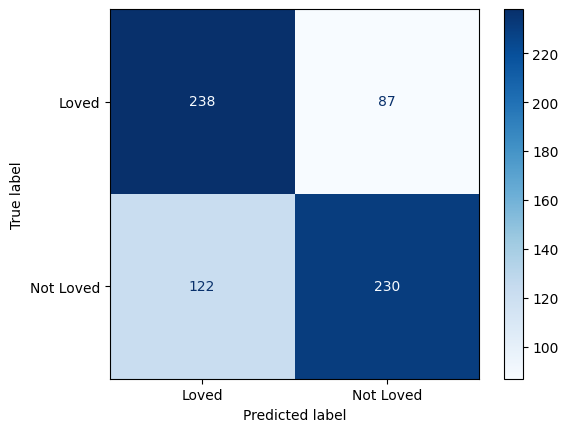

In [18]:
cm = confusion_matrix(y3_valid, rf_clas.predict(X_valid))
ConfusionMatrixDisplay(cm, display_labels= ["Loved", "Not Loved"]).plot(cmap= 'Blues')